# Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook, we're going to go through an example machine
learning project with the goal of predicting the sale price of 
bulldozers.

## 1. Problem definition

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/competitions/bluebook-for-bulldozers/data

The datasets is divided into three parts:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check:
https://www.kaggle.com/competitions/bluebook-for-bulldozers/overview/evaluation

**Note:** the goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimizes RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data ditionary on data folder of this projects.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Importing and analysing the data.
df = pd.read_csv('data/bluebook-for-bulldozers/TrainAndValid.csv',low_memory=False)

In [3]:
df.shape

(412698, 53)

In [4]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

In [5]:
df.SalePrice

0         66000.0
1         57000.0
2         10000.0
3         38500.0
4         11000.0
           ...   
412693    10000.0
412694    10500.0
412695    12500.0
412696    10000.0
412697    13000.0
Name: SalePrice, Length: 412698, dtype: float64

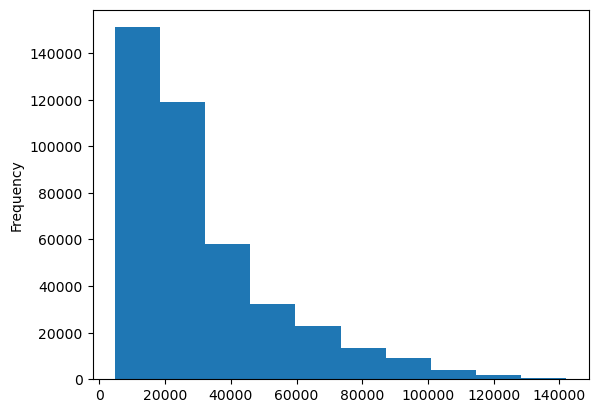

In [6]:
df.SalePrice.plot(kind='hist');

In [7]:
# Changing the 'saledate' dtype to pandas datetime dtype.
df = pd.read_csv('data/bluebook-for-bulldozers/TrainAndValid.csv',
                 low_memory=False,
                parse_dates=['saledate'])

In [8]:
df.saledate

0        2006-11-16
1        2004-03-26
2        2004-02-26
3        2011-05-19
4        2009-07-23
            ...    
412693   2012-03-07
412694   2012-01-28
412695   2012-01-28
412696   2012-03-07
412697   2012-01-28
Name: saledate, Length: 412698, dtype: datetime64[ns]

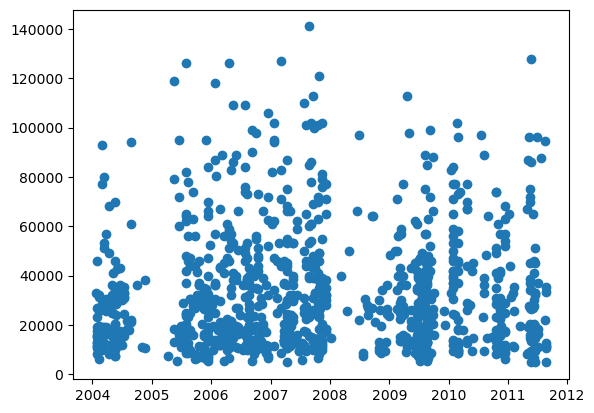

In [9]:
# Visualizing the saledate with saleprice column.
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000]);

In [10]:
# Making copy of the original dataframe.
df_temp = df.copy()

In [11]:
# Sorting the copy with saledate.
df_temp.sort_values(by=['saledate'],inplace=True, ascending=True)

In [12]:
df_temp

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410879,6302984,16000.0,1915521,5266,149,99.0,2001,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN
412476,6324811,6000.0,1919104,19330,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411927,6313029,16000.0,1918416,17244,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
407124,6266251,55000.0,509560,3357,149,99.0,1993,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Enriching the dataFrame with more date time columns.
df_temp['SaleYear'] = df_temp.saledate.dt.year
df_temp['SaleMonth'] = df_temp.saledate.dt.month
df_temp['SaleDay'] = df_temp.saledate.dt.day
df_temp['SaleDayofWeek'] = df_temp.saledate.dt.day_of_week
df_temp['SaleDayofYear'] = df_temp.saledate.dt.day_of_year

In [14]:
# Since we have enrich the dataframe with seperate date columns, Therefore we can remove 'saledate' column.
df_temp.drop('saledate',axis=1,inplace=True)

In [15]:
df_temp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [16]:
# Converting all the object type dtypes into categories.
for features, contents in df_temp.items():
    if pd.api.types.is_string_dtype(contents) is True:
        df_temp[features] = contents.astype('category').cat.as_ordered()   

In [17]:
df_temp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

In [18]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [19]:
#saving the df_temp.
#df_temp.to_csv('data/bluebook-for-bulldozers/Train-Valid-Temp-cat.csv', index=False)

In [20]:
#df_temp_ct = pd.read_csv('data/bluebook-for-bulldozers/Train-Valid-Temp-cat.csv',low_memory=False)

In [21]:
# Filling all the numreic columns with their respective median()
for features, contents in df_temp.items():
    if pd.api.types.is_numeric_dtype(contents) is True:
        if df_temp[features].isna().sum():
            #creating a additional column so we could know that if the value is original or inserted median.
            df_temp[features+'_is_missing'] = df_temp[features].isnull()
            df_temp[features] = df_temp[features].fillna(df_temp[features].median())

In [22]:
# Checking if the above code work or not?
for features, contents in df_temp.items():
    if pd.api.types.is_numeric_dtype(contents):
        if df_temp[features].isna().sum():
            print(features)

In [23]:
df_temp['auctioneerID_is_missing'].value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [24]:
df_temp.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

In [25]:
# Checking the non-numeric type dtype.
for features, contents in df_temp.items():
    if not pd.api.types.is_numeric_dtype(contents):
        print(features)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [26]:
# Filling the missing values which are not numeric.
for features, contents in df_temp.items():
    if not pd.api.types.is_numeric_dtype(contents):
            # Creating a additional column so we could know that if the value is original or inserted median.
            df_temp[features+'_is_missing_values'] = df_temp[features].isnull()
            df_temp[features] = pd.Categorical(contents).codes + 1

In [27]:
# Checking if the above code work.
for features, contents in df_temp.items():
    if not pd.api.types.is_numeric_dtype(contents):
        if df_temp[features].isna().sum():
            print(features)

# 5. Modelling


In [28]:
# Importing the model.
model = RandomForestRegressor(n_jobs=-1,
                             random_state=0)

In [29]:
# Splitting the test and valid data.
df_temp_test = df_temp[df_temp.SaleYear != 2012]
df_temp_valid = df_temp[df_temp.SaleYear == 2012]

In [30]:
# Successfully splitted the data.
df_temp_valid.shape, df_temp_test.shape

((11573, 103), (401125, 103))

In [31]:
%%time
# fitting the test data in our model.
model.fit(df_temp_test.drop('SalePrice',axis=1), df_temp_test.SalePrice)

CPU times: user 35min 22s, sys: 17.1 s, total: 35min 39s
Wall time: 9min 55s


RandomForestRegressor(n_jobs=-1, random_state=0)

In [32]:
# Checking the score for the model.
model.score(df_temp_test.drop('SalePrice',axis=1), df_temp_test.SalePrice)

0.9875232118608712

In [33]:
# Naming the above data.
X_train, y_train = df_temp_test.drop('SalePrice',axis=1), df_temp_test.SalePrice
X_valid, y_valid= df_temp_valid.drop('SalePrice',axis=1), df_temp_valid.SalePrice

In [34]:
X_train.shape,y_train.shape,X_valid.shape,y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

# 6. Evaluation

In [35]:
# Building the root mean square log error.

def rmsle(y_true, y_predict):
    '''This function takes the y_true and y_predict and produces the root mean square log error.
    y_true: The original dataset which is to be predicted.
    y_predict: The perdicted dataset from the model.
    '''
    
    result = np.sqrt(mean_squared_log_error(y_true, y_predict))
    return result

# Building all the important evaluation metrics for the regression metrics available to us.

def get_score(model,y_valid, X_valid):
    '''This function produces all the important evaluation scores for the regression metrics available in sklearn.
    i.e 
      1. mean square log error.
      2. mean square error.
      3. mean absolute error.
      4. r2 score
      
      and self designed.
      
      5. root mean square log error.
      
      Parameter taken:-
      model: estimater
      y_valid: Validation original dataset.
      X_valid: Validation test dataset.
      '''

    y_predict = model.predict(X_valid)
    
    result_dict = {'MSLE' : mean_squared_log_error(y_valid, y_predict),
                   'MSE'  : mean_squared_error(y_valid, y_predict),
                   'MAE'  : mean_absolute_error(y_valid, y_predict),
                   'r2'   : r2_score(y_valid, y_predict),
                   'RMSLE': rmsle(y_valid, y_predict)}
    return result_dict

In [36]:
get_score(model, y_valid, X_valid)

{'MSLE': 0.06427149444641957,
 'MSE': 86780680.90333517,
 'MAE': 6101.955356433077,
 'r2': 0.8736582236544965,
 'RMSLE': 0.253518232966427}

In [37]:
%%time
# Testing the model using different hyper-parameters.
grid = {'n_estimators': np.arange(10,100,10),
        'max_depth': [None,3,5,10],
        'min_samples_split': np.arange(2,20,2),
        'min_samples_leaf': np.arange(1,20,2),
        'max_features': [0.5,1,'sqrt'],
        'max_samples': [10000]}

rs_model = RandomizedSearchCV(model,
                             param_distributions=grid,
                             n_iter=2,
                             cv=5,
                             verbose=True)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: user 14.6 s, sys: 5.24 s, total: 19.9 s
Wall time: 1min 24s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=0),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [38]:
# Getting the best param for our model.
rs_model.best_params_

{'n_estimators': 90,
 'min_samples_split': 12,
 'min_samples_leaf': 15,
 'max_samples': 10000,
 'max_features': 1,
 'max_depth': None}

# Creating a new model using the best param we go above.

In [39]:
%%time
# Creating a new model using the best param we go above.
model_ideal = RandomForestRegressor(n_estimators=80,
                                   min_samples_split=4,
                                   min_samples_leaf=3,
                                   max_features=0.5,
                                   max_depth=None)
model_ideal.fit(X_train, y_train)

CPU times: user 6min 22s, sys: 3.39 s, total: 6min 25s
Wall time: 6min 28s


RandomForestRegressor(max_features=0.5, min_samples_leaf=3, min_samples_split=4,
                      n_estimators=80)

In [40]:
# Getting the score.
get_score(model_ideal,y_valid, X_valid)

{'MSLE': 0.058879342774171776,
 'MSE': 79887743.05649835,
 'MAE': 5881.2553534553745,
 'r2': 0.8836934757721719,
 'RMSLE': 0.24265065995000257}

# 7.  Predicting the test dataset.

In [41]:
# Importing the test data.
df_test = pd.read_csv('data/bluebook-for-bulldozers/Test.csv',parse_dates=['saledate'])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [42]:
# Processing the test dataset for model prediction.

def processing(df):
    '''This function process the dataset in accordance with the model/estimator requirement.
    PARAMETERS TAKEN:-
    1. df: dataframe dataset'''
    
    # Enriching the dataset.
    df['SaleYear'] = df.saledate.dt.year
    df['SaleMonth'] = df.saledate.dt.month
    df['SaleDay'] = df.saledate.dt.day
    df['SaleDayofWeek'] = df.saledate.dt.day_of_week
    df['SaleDayofYear'] = df.saledate.dt.day_of_year
    
    # Drop the trival saledate column.
    df.drop('saledate',axis=1,inplace=True)
    
    # Filling the missing data and coverting the non-numeric data into numeric.
    for features, contents in df.items():
        if pd.api.types.is_numeric_dtype(contents):
            # Filling the numeric data and taking the record of the missing data by adding another column of same name.
            if df[features].isna().sum():
                df[features+'_is_missing'] = df[features].isnull()
                df[features] = df[features].fillna(df[features].median())
                
        if not pd.api.types.is_numeric_dtype(contents):
            # Converting the non-numeric data and converting it into number.
            df[features+'_is_missing_values'] = df[features].isnull()
            df[features] = pd.Categorical(contents).codes + 1
            
    return df    

In [43]:
df_test = processing(df_test)

In [73]:
X_train.columns[56]

'auctioneerID_is_missing'

In [69]:
df_test.drop('auctioneerID_is_missing',axis=1, inplace=True)

In [74]:
df_test.insert(56,'auctioneerID_is_missing', False)

In [75]:
df_test.auctioneerID_is_missing

0        False
1        False
2        False
3        False
4        False
         ...  
12452    False
12453    False
12454    False
12455    False
12456    False
Name: auctioneerID_is_missing, Length: 12457, dtype: bool

In [76]:
y_df_test_pred = model_ideal.predict(df_test)

In [77]:
y_df_test_pred

array([16947.56295094, 17006.63205024, 48092.42776321, ...,
       13172.9880276 , 17953.68596681, 29096.62202381])

In [78]:
# Saving the above prediction in a data frame along with auctioneerID.
y_pred_dataframe = pd.DataFrame()
y_pred_dataframe['AuctioneerId'] = df_test['auctioneerID']
y_pred_dataframe['PredictedSalePrice'] = y_df_test_pred

In [83]:
y_pred_dataframe.columns.get_loc('PredictedSalePrice')

0

In [84]:
y_pred_dataframe.drop('SaleID',axis=1,inplace=True)
y_pred_dataframe.insert(0,'SaleID',df_test['SalesID'])
y_pred_dataframe.to_csv('data/bluebook-for-bulldozers/bulldozer-test-price-pricted.csv')

In [85]:
y_pred_dataframe

,SaleID,PredictedSalePrice
0,1227829,16947.562951
1,1227844,17006.632050
2,1227847,48092.427763
3,1227848,72802.001488
4,1227863,53388.715774
...,...,...
12452,6643171,42414.114358
12453,6643173,12856.982887
12454,6643184,13172.988028
12455,6643186,17953.685967


# Important Features

In [89]:
# Creating a function for visualizing the features importance.
def features_importance(columns, importance, n= 20):
    df = (pd.DataFrame({'Features': columns,
                  'Importance': importance})
                  .sort_values('Importance', ascending=False)
                  .reset_index(drop=True))
    
    fig, ax = plt.subplots()
    ax.barh(df['Features'][:n],df['Importance'][:n])
    ax.set_xlabel('Importance')
    ax.set_ylabel('Features')
    ax.invert_yaxis()

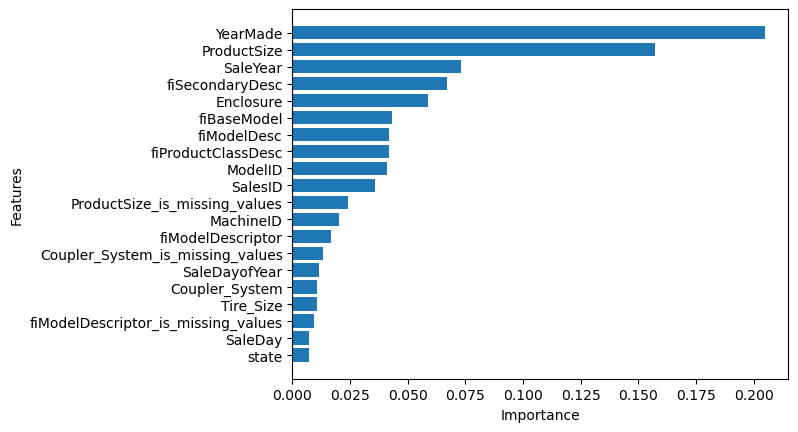

In [90]:
features_importance(X_train.columns, model_ideal.feature_importances_)